In [52]:
import matplotlib.pyplot as plt
from rlx import geo
import numpy as np
from rlx.utils import read_password_protected_zip, STANDARD_COLORS
%matplotlib inline
import shapely as sh
from rlx.utils import pbar
import pandas as pd
from skimage.io import imread
import os
reload(geo)
#API_key = read_password_protected_zip("google_apikey.zip")

<module 'rlx.geo' from '/Volumes/sdcard/opt/conda/lib/python2.7/site-packages/rlx/geo.pyc'>

# 1. create layer object

In [2]:
reload(geo)

BASEDIR = "/Users/rlx/datasets/google_maps/"
shapefile_name = BASEDIR+"/alcala_henares.catastro_urbano_sin_historia_28_05_UA_2018-01-20_SHF/CONSTRU.SHP"
L3 = geo.GoogleMaps_Shapefile_Layer("L3", shapefile_name, utm_zone_number=30, utm_zone_letter="T")

reading shapefile
converting to latlon
generating polygons


100% (96149 of 96149) |###################| Elapsed Time: 0:00:04 Time: 0:00:04


In [3]:
d = L3.shapefile
d.groupby("NUMSYMBOL")[["AREA"]].sum()

,AREA
NUMSYMBOL,
11,5780314.41
12,1121609.99
13,451976.17
14,78714.10
15,15097327.82
16,8768.09


# 2. Get list of existing images

In [53]:
from rlx.utils import command

_, imgs_fnames, _ = command("find "+BASEDIR+"/alcala_henares_20180211 -name '*jpg'")
len(imgs_fnames)

14001

splits test/train in half by latitude

In [54]:
latlons = np.r_[[list(np.r_[i.split("_")][[-7,-6]].astype(float)) for i in imgs_fnames]]
median = np.median(latlons, axis=0)
imgs_train = np.r_[imgs_fnames][[latlons[:,0]>median[0]]]
imgs_test  = np.r_[imgs_fnames][[latlons[:,0]<=median[0]]]

In [55]:
len(imgs_train), len(imgs_test), len(np.unique(list(imgs_train)+list(imgs_test)))

(7000, 7001, 14001)

# 3. Define coloring function for each multipolygon in shapefile

In [94]:
cat_cols = [[255,   0,   0], # red
            [255,   0, 255], # magenta
            [255, 128, 64],  # orange
            [  0,   0, 255], # blue
            [  0, 255,   0], # green 
            [  0, 128, 255], # cyan
            [255, 255, 255], # white
            [  0,   0,   0]] # black
            
cat_names = ["constr sobre", "constr bajo", "zona deport", "piscina/estanque", 
             "solar/patio", "parcela rustica", "sin parcela", "unknown"]
cat_codes = [11,12,13,14,15,16,0,-1]

dict_names = {cat_codes[i]:cat_names[i] for i in range(len(cat_names))}
dict_cols  = {cat_codes[i]:cat_cols[i] for i in range(len(cat_cols))}
dict_cols

{-1: [0, 0, 0],
 0: [255, 255, 255],
 11: [255, 0, 0],
 12: [255, 0, 255],
 13: [255, 128, 64],
 14: [0, 0, 255],
 15: [0, 255, 0],
 16: [0, 128, 255]}

check transformation to single channel image (pixel labels for segmentation)

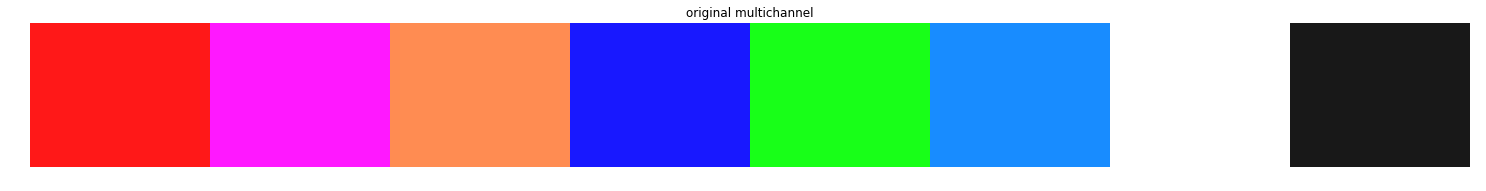

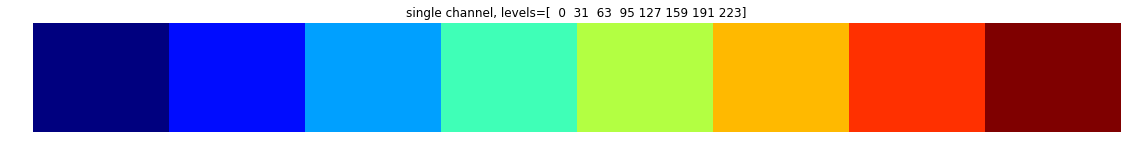

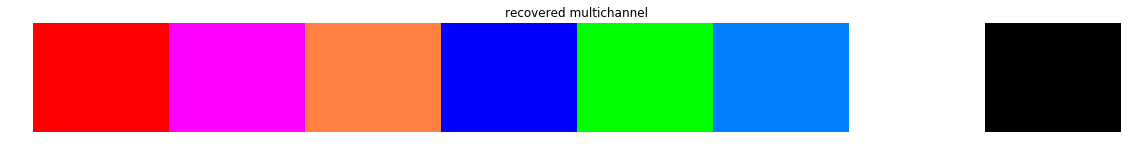

In [95]:
reload(geo)
geo.show_channel_map(cat_cols)

In [79]:
def func_label(record, alpha=0):
    
    c = record.NUMSYMBOL
    if c in dict_cols.keys():
        t = tuple(np.r_[dict_cols[c]]*1./255), alpha
        return t
    
    return (0,0,0), alpha # black in any other case

# 4. Load images and create corresponding layer

In [96]:
confs = [{ "color_func": lambda x: func_label(x, alpha=0), 
           "target_dir": BASEDIR+"/alcala_henares_20180211_L3_imgs_train/",
           "overlay_original": True, "verbose": False},
         
         { "color_func": lambda x: func_label(x, alpha=1), 
           "target_dir": BASEDIR+"/alcala_henares_20180211_L3_labels_train/",
           "overlay_original": False, "verbose": False},
         
         { "color_func": lambda x: func_label(x, alpha=.5), 
           "target_dir": BASEDIR+"/alcala_henares_20180211_L3_overlay_train/",
           "overlay_original": True, "verbose": False, "default_alpha": 0.5},
        
         { "color_func": lambda x: func_label(x, alpha=1), 
           "target_dir": BASEDIR+"/alcala_henares_20180211_L3_labels_single_channel_train/",
           "overlay_original": False, "verbose": False, "single_channel_map": cat_cols}
        
        ]


In [105]:
from joblib import delayed
from rlx.utils import mParallel

In [109]:
def generate_imgs(img_fname):
    fname = confs[0]["target_dir"]+"/"+(".".join(img_fname.split(".")[:-1])+"_%s%s.jpg"%("L3", "")).split("/")[-1]
    if os.path.isfile(fname):
        return
        
    k = geo.GoogleMaps_Static_Image.from_filename(img_fname)
    if k is None:
        return
    L3.save_layer_patches_for_gmaps_img(k, confs)
    
mParallel(n_jobs=-1, verbose=30)(delayed(generate_imgs)(i) for i in imgs_train[502:510]); 
    
#for img_fname in pbar()(imgs_train[502:510]):
#    generate_imgs(L3, img_fname)

 [mParallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   22.9s finishedg:    0.0s

In [103]:
del(LX)